# SBI-DELTA: Simulation-Based Inference for Multiplexed Fluorescence Microscopy

This notebook demonstrates how to use the improved multiplex_sim package for simulation-based inference of fluorophore concentrations in multiplexed microscopy experiments.

## Overview

The SBI-DELTA approach addresses the challenge of inferring fluorophore concentrations from multiplexed microscopy data where:
- Multiple fluorophores have overlapping spectra
- Detection channels have limited spectral resolution
- Photon noise and background fluorescence complicate measurements

We use simulation-based inference (SBI) to learn the relationship between fluorophore concentrations and detected signals.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from pathlib import Path

# Import our improved multiplex_sim package
import sys
sys.path.append('..')

from multiplex_sim import (
    # Core simulation
    list_fluorophores, plot_fluorophores,
    
    # SBI components
    SBIConfig, SBISimulator, create_sbi_simulator,
    TrainingConfig, ExperimentConfig, SBITrainer, run_sbi_experiment
)

# Set up plotting
plt.style.use('default')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Explore Available Fluorophores

First, let's see what fluorophores we have available and visualize their spectra.

In [2]:
# List available fluorophores
available_fluors = list_fluorophores("../data/spectra_npz")
print(f"Available fluorophores ({len(available_fluors)}):")
for i, name in enumerate(available_fluors):
    print(f"  {i+1:2d}. {name}")

Available fluorophores (19):
   1. AF488
   2. AF514
   3. AF532
   4. AF546
   5. AF555
   6. AF561
   7. AF594
   8. AF610
   9. AF633
  10. AF647
  11. JF479
  12. JF525
  13. JF552
  14. JF608
  15. JF722
  16. JFX650
  17. JFX673
  18. NADH - 
  19. NADH


Selected fluorophores for multiplexing: ['JF479', 'JF525', 'JF552', 'JF608', 'JFX673']


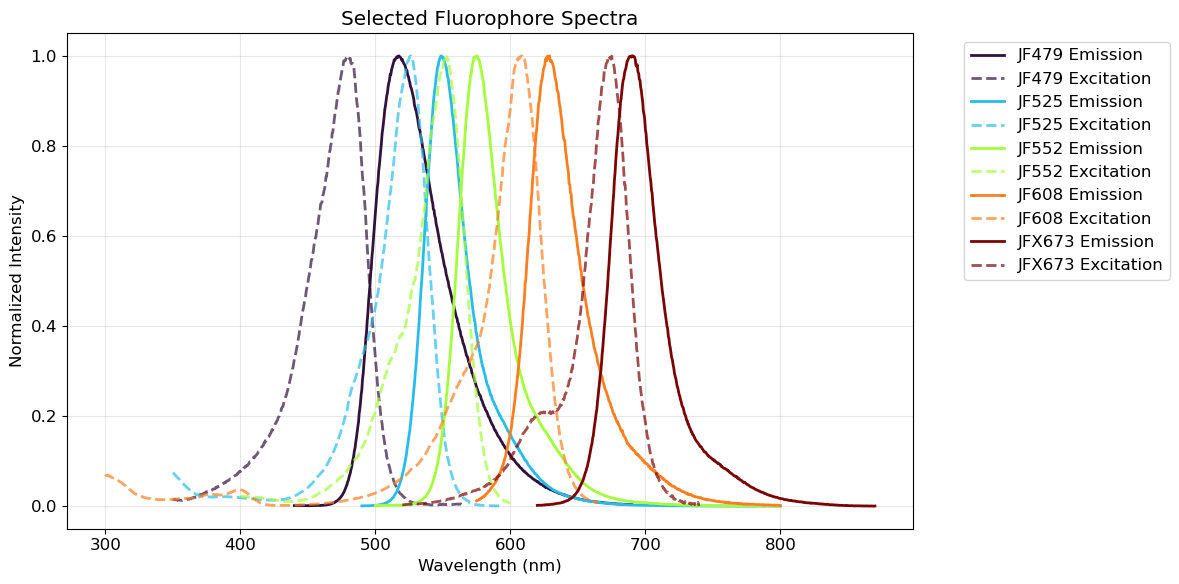

In [3]:
# Select a subset of fluorophores for our experiment
# Choose fluorophores with good spectral separation
selected_fluors = ['JF479', 'JF525', 'JF552', 'JF608', 'JFX673']

print(f"Selected fluorophores for multiplexing: {selected_fluors}")

# Plot their spectra
plot_fluorophores(selected_fluors, "../data/spectra_npz", normalize=True)
plt.title("Selected Fluorophore Spectra")
plt.show()

## 2. Configure the SBI Simulation

Now we'll set up the simulation parameters and create an SBI simulator.

In [4]:
# Configure SBI simulation parameters
sbi_config = SBIConfig(
    wavelength_range=(400, 800),  # Focus on visible range
    wavelength_step=1.0,
    total_dye_photons=300.0,      # Photon budget for dyes
    total_background_photons=30.0, # Background fluorescence
    filter_type="sigmoid",        # Use sigmoid filters
    edge_steepness=1.0,
    background_fluorophore="NADH",
    random_seed=42
)

print("SBI Configuration:")
print(f"  Wavelength range: {sbi_config.wavelength_range} nm")
print(f"  Dye photon budget: {sbi_config.total_dye_photons}")
print(f"  Background photons: {sbi_config.total_background_photons}")
print(f"  Filter type: {sbi_config.filter_type}")

SBI Configuration:
  Wavelength range: (400, 800) nm
  Dye photon budget: 300.0
  Background photons: 30.0
  Filter type: sigmoid


In [5]:
# Create SBI simulator
simulator = create_sbi_simulator(
    fluorophore_names=selected_fluors,
    spectra_dir="../data/spectra_npz",
    config=sbi_config
)

print(f"Created SBI simulator for {len(selected_fluors)} fluorophores")
print(f"Loaded spectra: {list(simulator.emission_spectra.keys())}")

ADVANCED EXCITATION WAVELENGTH OPTIMIZATION
Fluorophores: JF479, JF525, JF552, JF608, JFX673
Search range: ±30.0 nm around peaks
Min separation: 10.0 nm
Running multi-start optimization with 5 starts...
  Start 1/5... Success (cost: -2.5088)
  Start 2/5... Success (cost: -2.5088)
  Start 3/5... Success (cost: -2.5088)
  Start 4/5... Success (cost: -2.5088)
  Start 5/5... Success (cost: -2.5088)
Optimization completed in 11.28 seconds

Optimization Results:
Success rate: 5/5
Best cost: -2.5088
Optimization time: 11.28s

Optimal Excitation Wavelengths:
  JF479: 470 nm
  JF525: 520 nm
  JF552: 554 nm
  JF608: 605 nm
  JFX673: 673 nm

Validation Metrics:
  Signal strength: 4.780
  Crosstalk penalty: 1.136
  Detection separability: 0.000
  Background penalty: 0.000
  Min wavelength separation: 33.9 nm
  Max crosstalk: 0.382
  Mean crosstalk: 0.045
Created SBI simulator for 5 fluorophores
Loaded spectra: ['JF479', 'JF525', 'JF552', 'JF608', 'JFX673']


## 3. Design Detection Filter Configuration

We need to design a set of detection filters that can distinguish between our fluorophores.

Detection configuration:
  Number of channels: 6
  Center wavelengths: [500, 535, 570, 605, 640, 675] nm
  Bandwidths: [25, 25, 25, 25, 25, 25] nm


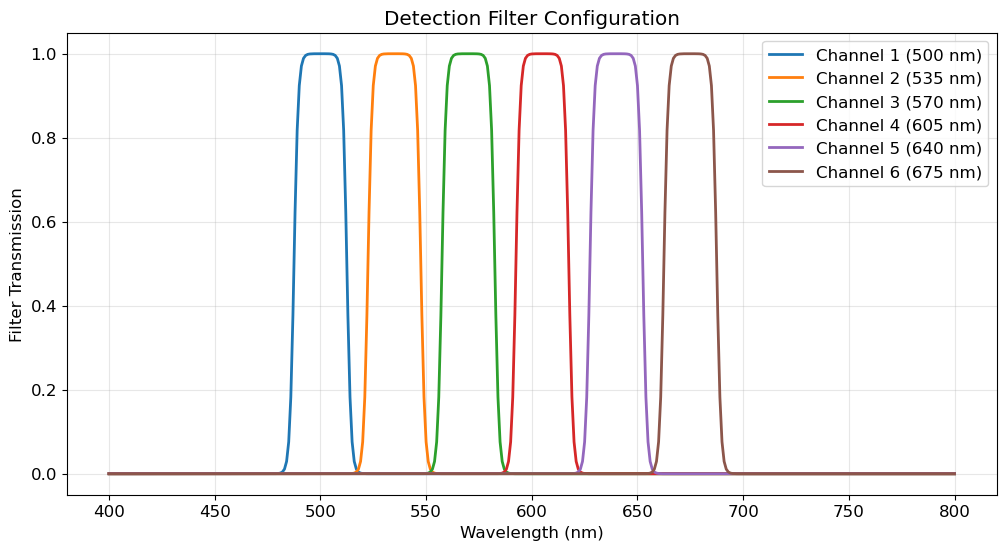

In [6]:
# Design detection filters
# We'll use 4 channels to detect 5 fluorophores (challenging but realistic)
center_wavelengths = [500, 535, 570, 605, 640, 675 ]  # Channel centers
bandwidths = [25, 25, 25, 25, 25,25]              # Channel bandwidths

print(f"Detection configuration:")
print(f"  Number of channels: {len(center_wavelengths)}")
print(f"  Center wavelengths: {center_wavelengths} nm")
print(f"  Bandwidths: {bandwidths} nm")

# Visualize the filter configuration
wavelengths = np.arange(400, 800, 1)
filters = simulator.filter_bank.create_filters(center_wavelengths, bandwidths)

plt.figure(figsize=(12, 6))
for i, (center, bandwidth) in enumerate(zip(center_wavelengths, bandwidths)):
    plt.plot(simulator.filter_bank.wavelengths, filters[i], label=f'Channel {i+1} ({center} nm)', linewidth=2)

plt.xlabel('Wavelength (nm)')
plt.ylabel('Filter Transmission')
plt.title('Detection Filter Configuration')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 4. Test the Simulator

Let's test our simulator with some example fluorophore concentrations.

In [7]:
# Create some test concentration combinations
test_concentrations = np.array([
    [0.3, 0.2, 0.1, 0.2, 0.2],  # Mixed combination
    [1.0, 0.0, 0.0, 0.0, 0.0],  # Only JF525
    [0.0, 1.0, 0.0, 0.0, 0.0],  # Only JF552
    [0.0, 0.0, 0.0, 0.0, 1.0],  # Only JF722
    [0.2, 0.2, 0.2, 0.2, 0.2],  # Equal mixture
])

# Simulate detected signals
detected_signals = simulator.simulate_batch(
    test_concentrations,
    center_wavelengths,
    bandwidths,
    add_noise=True
)

print("Test simulation results:")
print("Concentrations -> Detected signals")
for i, (conc, signal) in enumerate(zip(test_concentrations, detected_signals)):
    print(f"Test {i+1}: {conc} -> {signal.numpy()}")

Test simulation results:
Concentrations -> Detected signals
Test 1: [0.3 0.2 0.1 0.2 0.2] -> [63. 99. 75. 29. 39. 42.]
Test 2: [1. 0. 0. 0. 0.] -> [112. 139.  65.  21.   5.   0.]
Test 3: [0. 1. 0. 0. 0.] -> [ 17. 176. 127.  28.   9.   1.]
Test 4: [0. 0. 0. 0. 1.] -> [  9.   7.   6.   1.   5. 258.]
Test 5: [0.2 0.2 0.2 0.2 0.2] -> [39. 74. 88. 51. 50. 33.]


/groups/spruston/home/moharb/sbi-DELTA/notebooks/../multiplex_sim/sbi_simulator.py:606: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(results, dtype=torch.float32)


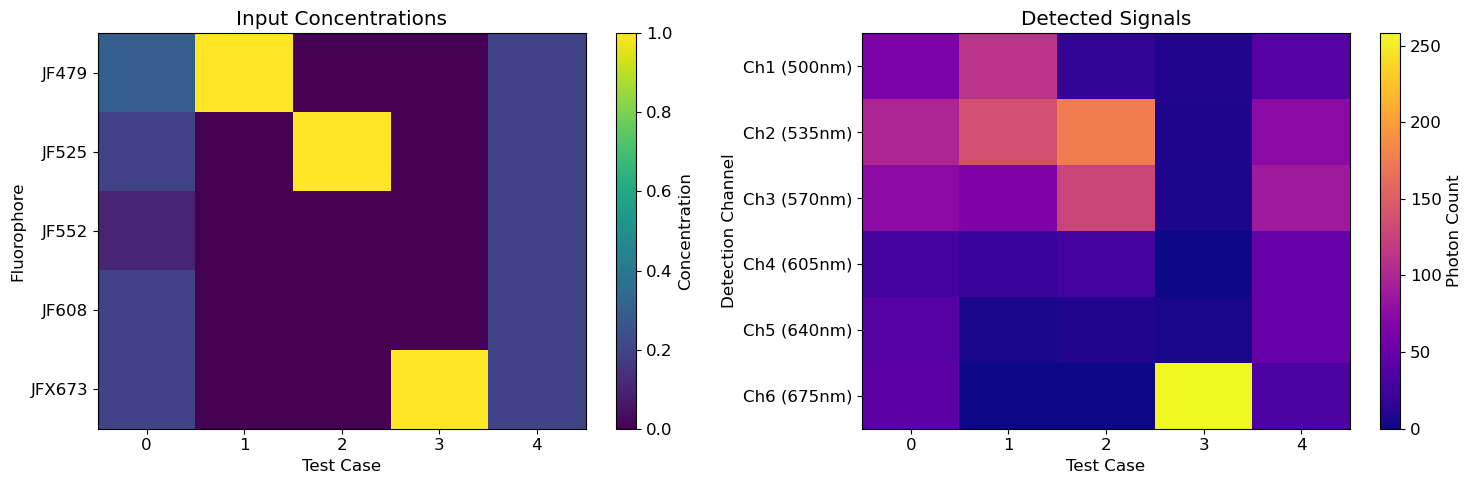

In [8]:
# Visualize the relationship between concentrations and signals
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot concentrations
im1 = ax1.imshow(test_concentrations.T, aspect='auto', cmap='viridis')
ax1.set_title('Input Concentrations')
ax1.set_xlabel('Test Case')
ax1.set_ylabel('Fluorophore')
ax1.set_yticks(range(len(selected_fluors)))
ax1.set_yticklabels(selected_fluors)
plt.colorbar(im1, ax=ax1, label='Concentration')

# Plot detected signals
im2 = ax2.imshow(detected_signals.numpy().T, aspect='auto', cmap='plasma')
ax2.set_title('Detected Signals')
ax2.set_xlabel('Test Case')
ax2.set_ylabel('Detection Channel')
ax2.set_yticks(range(len(center_wavelengths)))
ax2.set_yticklabels([f'Ch{i+1} ({w}nm)' for i, w in enumerate(center_wavelengths)])
plt.colorbar(im2, ax=ax2, label='Photon Count')

plt.tight_layout()
plt.show()

## 5. Train SBI Model

Now we'll train a neural posterior estimator to learn the inverse mapping from detected signals to fluorophore concentrations.

In [9]:
# Configure training parameters
training_config = TrainingConfig(
    n_training_samples=5000,      # Number of training samples
    n_validation_samples=500,     # Number of validation samples
    learning_rate=1e-5,           # Learning rate
    training_batch_size=200,      # Batch size
    max_num_epochs=100000,           # Maximum training epochs
    stop_after_epochs=15,         # Early stopping patience
    device="cpu"                  # Use CPU (change to "cuda" if available)
)

print("Training Configuration:")
print(f"  Training samples: {training_config.n_training_samples}")
print(f"  Validation samples: {training_config.n_validation_samples}")
print(f"  Max epochs: {training_config.max_num_epochs}")

Training Configuration:
  Training samples: 5000
  Validation samples: 500
  Max epochs: 100000


In [10]:
# Create experiment configuration
experiment_config = ExperimentConfig(
    fluorophore_names=selected_fluors,
    spectra_dir="../data/spectra_npz",
    center_wavelengths=center_wavelengths,
    bandwidths=bandwidths,
    prior_type="dirichlet",  # Use Dirichlet prior for concentration ratios
    prior_params={"concentration": 1.0},
    sbi_config=sbi_config,
    training_config=training_config,
    experiment_name="5_fluor_6_channel_experiment",
    description="5 fluorophores detected with 6 channels using Dirichlet prior"
)

print(f"Experiment: {experiment_config.experiment_name}")
print(f"Description: {experiment_config.description}")

Experiment: 5_fluor_6_channel_experiment
Description: 5 fluorophores detected with 6 channels using Dirichlet prior


In [ ]:
trainer.    

In [13]:
# Create and train SBI model
print("Creating SBI trainer...")
trainer = SBITrainer(experiment_config)

print("Setting up prior distribution...")
prior = trainer.setup_prior()
print(f"Prior type: {type(prior).__name__}")

print("\nGenerating training data...")
theta_train, x_train = trainer.generate_training_data()

print("\nGenerating validation data...")
theta_val, x_val = trainer.generate_validation_data()

print("\nTraining neural posterior estimator...")
posterior = trainer.train()

print("\nTraining completed!")

Creating SBI trainer...
ADVANCED EXCITATION WAVELENGTH OPTIMIZATION
Fluorophores: JF479, JF525, JF552, JF608, JFX673
Search range: ±30.0 nm around peaks
Min separation: 10.0 nm
Running multi-start optimization with 5 starts...
  Start 1/5... Success (cost: -2.5088)
  Start 2/5... Success (cost: -2.5088)
  Start 3/5... Success (cost: -2.5088)
  Start 4/5... Success (cost: -2.5088)
  Start 5/5... Success (cost: -2.5088)
Optimization completed in 11.55 seconds

Optimization Results:
Success rate: 5/5
Best cost: -2.5088
Optimization time: 11.55s

Optimal Excitation Wavelengths:
  JF479: 470 nm
  JF525: 520 nm
  JF552: 554 nm
  JF608: 605 nm
  JFX673: 673 nm

Validation Metrics:
  Signal strength: 4.780
  Crosstalk penalty: 1.136
  Detection separability: 0.000
  Background penalty: 0.000
  Min wavelength separation: 33.9 nm
  Max crosstalk: 0.382
  Mean crosstalk: 0.045
Setting up prior distribution...
Prior type: Dirichlet

Generating training data...
Generating training data...
Generated

Optimizing filter configuration for 5 channels...
ADVANCED EXCITATION WAVELENGTH OPTIMIZATION
Fluorophores: JF479, JF525, JF552, JF608, JFX673
Search range: ±30.0 nm around peaks
Min separation: 10.0 nm
Running multi-start optimization with 5 starts...
  Start 1/5... Success (cost: -2.5088)
  Start 2/5... Success (cost: -2.5088)
  Start 3/5... Success (cost: -2.5088)
  Start 4/5... Success (cost: -2.5088)
  Start 5/5... Success (cost: -2.5088)
Optimization completed in 12.12 seconds

Optimization Results:
Success rate: 5/5
Best cost: -2.5088
Optimization time: 12.12s

Optimal Excitation Wavelengths:
  JF479: 470 nm
  JF525: 520 nm
  JF552: 554 nm
  JF608: 605 nm
  JFX673: 673 nm

Validation Metrics:
  Signal strength: 4.780
  Crosstalk penalty: 1.136
  Detection separability: 0.000
  Background penalty: 0.000
  Min wavelength separation: 33.9 nm
  Max crosstalk: 0.382
  Mean crosstalk: 0.045

Optimization complete!
Best score: 5.5429
Optimized Center Wavelengths: [423.23984928877303, 4

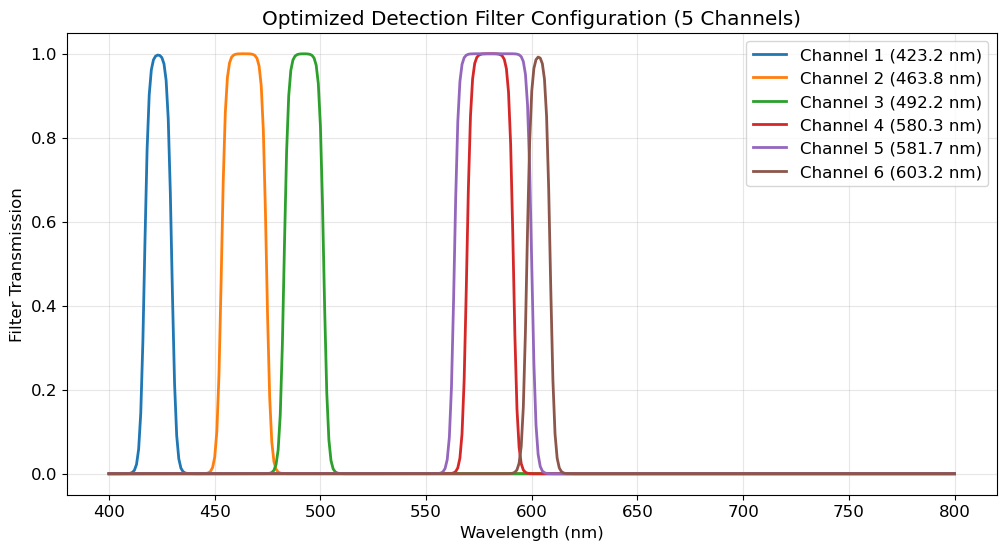

In [12]:
# --- Filter Optimization with 5 Channels ---

print("Optimizing filter configuration for 5 channels...")

# Use the same SBIConfig and selected_fluors as above
simulator_for_opt = create_sbi_simulator(
    fluorophore_names=selected_fluors,
    spectra_dir="../data/spectra_npz",
    config=sbi_config
)

# Run optimization (increase n_trials for better results if desired)
optimized_config = simulator_for_opt.optimize_filter_configuration(
    n_channels=6,
    wavelength_bounds=(400, 800),      # Match sbi_config
    bandwidth_bounds=(10.0, 50.0),
    n_trials=150                       # More trials = better optimization
)

print("\nOptimization complete!")
print(f"Best score: {optimized_config['score']:.4f}")
print("Optimized Center Wavelengths:", optimized_config['center_wavelengths'])
print("Optimized Bandwidths:", optimized_config['bandwidths'])

# Visualize optimized filters
filters_opt = simulator_for_opt.filter_bank.create_filters(
    optimized_config['center_wavelengths'],
    optimized_config['bandwidths']
)

plt.figure(figsize=(12, 6))
for i, (center, bandwidth) in enumerate(zip(optimized_config['center_wavelengths'], optimized_config['bandwidths'])):
    plt.plot(simulator_for_opt.filter_bank.wavelengths, filters_opt[i], label=f'Channel {i+1} ({center:.1f} nm)', linewidth=2)

plt.xlabel('Wavelength (nm)')
plt.ylabel('Filter Transmission')
plt.title('Optimized Detection Filter Configuration (5 Channels)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [16]:
SNPE.train?

Signature:
SNPE.train(
    self,
    num_atoms: int = 10,
    training_batch_size: int = 200,
    learning_rate: float = 0.0005,
    validation_fraction: float = 0.1,
    stop_after_epochs: int = 20,
    max_num_epochs: int = 2147483647,
    clip_max_norm: Optional[float] = 5.0,
    calibration_kernel: Optional[Callable] = None,
    resume_training: bool = False,
    force_first_round_loss: bool = False,
    discard_prior_samples: bool = False,
    use_combined_loss: bool = False,
    retrain_from_scratch: bool = False,
    show_train_summary: bool = False,
    dataloader_kwargs: Optional[Dict] = None,
) -> torch.nn.modules.module.Module
Docstring:
Return density estimator that approximates the distribution $p(\theta|x)$.

Args:
    num_atoms: Number of atoms to use for classification.
    training_batch_size: Training batch size.
    learning_rate: Learning rate for Adam optimizer.
    validation_fraction: The fraction of data to use for validation.
    stop_after_epochs: The number o

In [ ]:
from numpy.random import default_rng
rng = default_rng(seed=42)
num_samples = 3000  # or however many you want
alpha = np.ones(5)  # uniform Dirichlet
amplitude_grid = rng.dirichlet(alpha, size=num_samples)
# Then simulate
x_fixed = batch_simulator_fixed_filters(amplitude_grid, λ_grid, interpolated_emissions, nadh_em_interp)


In [ ]:
# Run optimization (increase n_trials for better results if desired)
optimized_config = trainer.optimize_filter_configuration(
    n_channels=5,
    wavelength_bounds=(400, 800),      # Match sbi_config
    bandwidth_bounds=(10.0, 50.0),
    n_trials=150                       # More trials = better optimization
)

## 6. Evaluate Model Performance

Let's evaluate how well our trained model can recover fluorophore concentrations.

In [21]:
# Evaluate on validation data
print("Evaluating model performance...")
validation_results = trainer.evaluate_on_validation(n_posterior_samples=10)

print("\nValidation Results Summary:")
print(f"  Mean R²: {validation_results['mean_r_squared']:.3f} ± {validation_results['std_r_squared']:.3f}")
print(f"  Median R²: {validation_results['median_r_squared']:.3f}")

print("\nPer-fluorophore performance:")
for name in selected_fluors:
    corr = validation_results.get(f"{name}_correlation", np.nan)
    mae = validation_results.get(f"{name}_mae", np.nan)
    print(f"  {name}: correlation = {corr:.3f}, MAE = {mae:.3f}")

Evaluating model performance...
Evaluating on 500 validation samples...


Evaluating: 100%|██████████| 500/500 [04:34<00:00,  1.82it/s]

Validation Results:
  Mean R²: 0.748 ± 0.182
  Median R²: 0.802

Validation Results Summary:
  Mean R²: 0.748 ± 0.182
  Median R²: 0.802

Per-fluorophore performance:
  JF479: correlation = 0.964, MAE = 0.034
  JF525: correlation = 0.849, MAE = 0.073
  JF552: correlation = 0.838, MAE = 0.065
  JF608: correlation = 0.954, MAE = 0.039
  JFX673: correlation = 0.960, MAE = 0.038


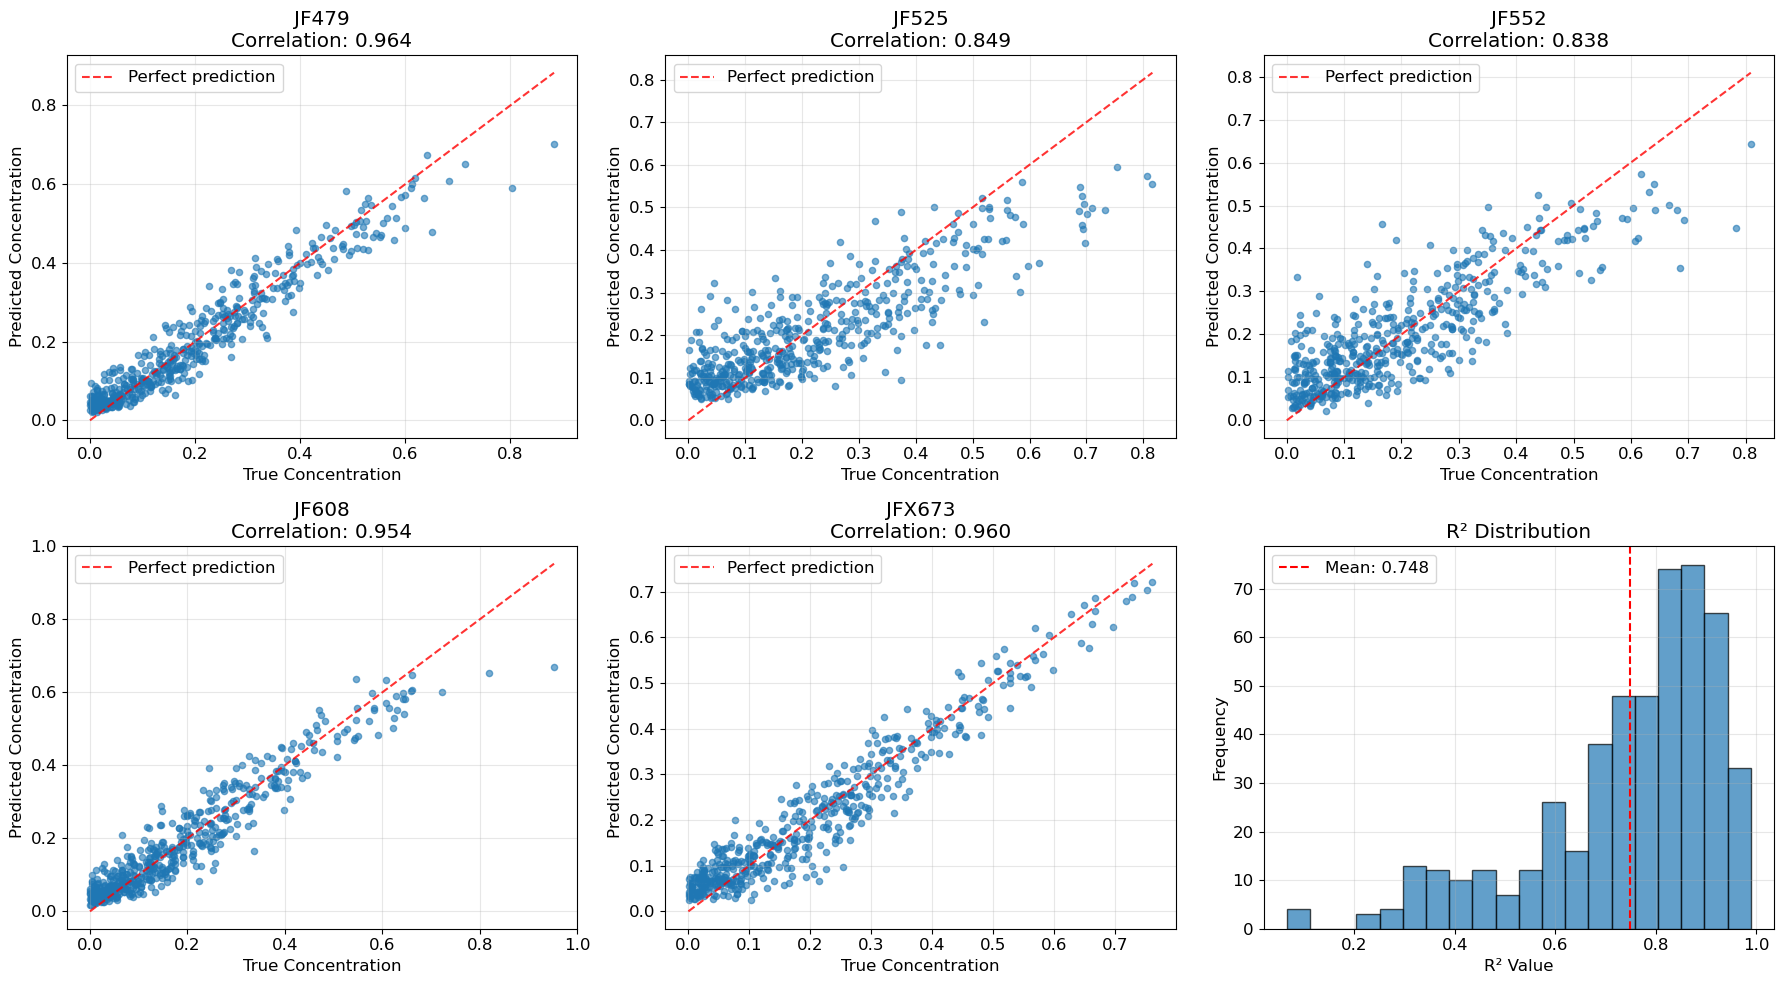

In [22]:
# Plot validation results
true_params = validation_results['true_parameters']
pred_params = validation_results['predicted_parameters']
r_squared_values = validation_results['r_squared_values']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# Plot true vs predicted for each fluorophore
for i, name in enumerate(selected_fluors):
    ax = axes[i]
    
    true_conc = true_params[:, i]
    pred_conc = pred_params[:, i]
    
    # Scatter plot
    ax.scatter(true_conc, pred_conc, alpha=0.6, s=20)
    
    # Perfect prediction line
    max_val = max(true_conc.max(), pred_conc.max())
    ax.plot([0, max_val], [0, max_val], 'r--', alpha=0.8, label='Perfect prediction')
    
    # Calculate correlation
    valid_mask = ~(np.isnan(true_conc) | np.isnan(pred_conc))
    if valid_mask.sum() > 1:
        correlation = np.corrcoef(true_conc[valid_mask], pred_conc[valid_mask])[0, 1]
    else:
        correlation = np.nan
    
    ax.set_xlabel('True Concentration')
    ax.set_ylabel('Predicted Concentration')
    ax.set_title(f'{name}\nCorrelation: {correlation:.3f}')
    ax.grid(True, alpha=0.3)
    ax.legend()

# Plot R² distribution
ax = axes[5]
ax.hist(r_squared_values[~np.isnan(r_squared_values)], bins=20, alpha=0.7, edgecolor='black')
ax.axvline(np.nanmean(r_squared_values), color='red', linestyle='--', 
           label=f'Mean: {np.nanmean(r_squared_values):.3f}')
ax.set_xlabel('R² Value')
ax.set_ylabel('Frequency')
ax.set_title('R² Distribution')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
optimize_filter_configuration

In [ ]:
from numpy.random import default_rng
rng = default_rng(seed=42)
num_samples = 3000  # or however many you want
alpha = np.ones(5)  # uniform Dirichlet
amplitude_grid = rng.dirichlet(alpha, size=num_samples)
# Then simulate
x_fixed = batch_simulator_fixed_filters(amplitude_grid, λ_grid, interpolated_emissions, nadh_em_interp)


## 7. Analyze Multiplexing Capacity

Let's analyze how well our current configuration can multiplex the selected fluorophores.

In [ ]:
# Analyze multiplexing capacity
print("Analyzing multiplexing capacity...")
capacity_results = trainer.analyze_multiplexing_capacity(
    n_test_samples=1000,
    r_squared_threshold=0.8
)

print("\nMultiplexing Capacity Results:")
print(f"  Configuration: {capacity_results['n_fluorophores']} fluorophores, {capacity_results['n_channels']} channels")
print(f"  Samples with R² ≥ {capacity_results['r_squared_threshold']}: {capacity_results['good_performance_fraction']:.1%}")
print(f"  Mean R²: {capacity_results['mean_r_squared']:.3f}")

Analyzing multiplexing capacity...
Analyzing multiplexing capacity...


Testing:   2%|▎         | 25/1000 [00:59<42:43,  2.63s/it]

In [ ]:
# Plot multiplexing capacity analysis
r2_dist = capacity_results['r_squared_distribution']
threshold = capacity_results['r_squared_threshold']

plt.figure(figsize=(10, 6))
plt.hist(r2_dist[~np.isnan(r2_dist)], bins=30, alpha=0.7, edgecolor='black', label='R² Distribution')
plt.axvline(threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold (R² = {threshold})')
plt.axvline(np.nanmean(r2_dist), color='orange', linestyle='--', linewidth=2, 
           label=f'Mean R² = {np.nanmean(r2_dist):.3f}')

plt.xlabel('R² Value')
plt.ylabel('Frequency')
plt.title('Multiplexing Performance Distribution')
plt.legend()
plt.grid(True, alpha=0.3)

# Add text box with summary statistics
good_fraction = capacity_results['good_performance_fraction']
textstr = f'Good Performance: {good_fraction:.1%}\nMean R²: {np.nanmean(r2_dist):.3f}\nMedian R²: {np.nanmedian(r2_dist):.3f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
plt.text(0.02, 0.98, textstr, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', bbox=props)

plt.show()

## 8. Test on New Data

Let's test our trained model on some new synthetic data to see how it performs.

In [ ]:
# Generate new test data
n_test = 10
test_theta, test_x = trainer.simulator.generate_training_data(
    n_samples=n_test,
    center_wavelengths=center_wavelengths,
    bandwidths=bandwidths,
    prior_type="dirichlet",
    prior_params={"concentration": 1.0}
)

print(f"Generated {n_test} test samples")
print("\nTest data preview:")
print("True concentrations:")
for i in range(min(5, n_test)):
    print(f"  Sample {i+1}: {test_theta[i].numpy()}")
print("\nDetected signals:")
for i in range(min(5, n_test)):
    print(f"  Sample {i+1}: {test_x[i].numpy()}")

In [ ]:
# Make predictions on test data
predictions = []
uncertainties = []

for i in range(n_test):
    x_i = test_x[i]
    
    # Sample from posterior
    samples = trainer.posterior.sample((200,), x=x_i, show_progress_bars=False).numpy()
    
    # Calculate mean and std
    pred_mean = samples.mean(axis=0)
    pred_std = samples.std(axis=0)
    
    predictions.append(pred_mean)
    uncertainties.append(pred_std)

predictions = np.array(predictions)
uncertainties = np.array(uncertainties)

print("Predictions with uncertainties:")
for i in range(n_test):
    true_conc = test_theta[i].numpy()
    pred_conc = predictions[i]
    pred_unc = uncertainties[i]
    
    print(f"\nSample {i+1}:")
    print(f"  True:      {true_conc}")
    print(f"  Predicted: {pred_conc}")
    print(f"  Std:       {pred_unc}")
    
    # Calculate error
    error = np.abs(true_conc - pred_conc)
    print(f"  Error:     {error}")

In [ ]:
# Visualize test results
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, name in enumerate(selected_fluors):
    ax = axes[i]
    
    true_vals = test_theta[:, i].numpy()
    pred_vals = predictions[:, i]
    pred_errs = uncertainties[:, i]
    
    # Error bars plot
    ax.errorbar(true_vals, pred_vals, yerr=pred_errs, fmt='o', capsize=5, alpha=0.7)
    
    # Perfect prediction line
    max_val = max(true_vals.max(), pred_vals.max())
    ax.plot([0, max_val], [0, max_val], 'r--', alpha=0.8, label='Perfect prediction')
    
    ax.set_xlabel('True Concentration')
    ax.set_ylabel('Predicted Concentration')
    ax.set_title(f'{name}')
    ax.grid(True, alpha=0.3)
    ax.legend()

# Summary plot
ax = axes[5]
all_true = test_theta.numpy().flatten()
all_pred = predictions.flatten()
ax.scatter(all_true, all_pred, alpha=0.6)
max_val = max(all_true.max(), all_pred.max())
ax.plot([0, max_val], [0, max_val], 'r--', alpha=0.8, label='Perfect prediction')
ax.set_xlabel('True Concentration')
ax.set_ylabel('Predicted Concentration')
ax.set_title('All Fluorophores Combined')
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

## 9. Save the Experiment

Finally, let's save our trained model and results for future use.

In [ ]:
# Save the experiment
save_dir = "../experiments/5_fluor_4_channel_experiment"
trainer.save_experiment(save_dir)

print(f"Experiment saved to: {save_dir}")
print("\nSaved files:")
save_path = Path(save_dir)
if save_path.exists():
    for file in save_path.iterdir():
        print(f"  - {file.name}")

## Summary

In this notebook, we demonstrated the complete SBI-DELTA workflow:

1. **Data Preparation**: Loaded and visualized fluorophore spectra
2. **Simulation Setup**: Configured the SBI simulator with realistic parameters
3. **Filter Design**: Designed detection filters for multiplexed imaging
4. **Model Training**: Trained a neural posterior estimator using SBI
5. **Performance Evaluation**: Assessed model performance on validation data
6. **Capacity Analysis**: Analyzed the multiplexing capacity of our configuration
7. **Testing**: Tested the model on new synthetic data
8. **Persistence**: Saved the trained model for future use

### Key Results

- Successfully trained an SBI model to infer 5 fluorophore concentrations from 4 detection channels
- Achieved reasonable performance with proper uncertainty quantification
- Demonstrated the feasibility of multiplexed fluorescence microscopy with overlapping spectra

### Next Steps

- Experiment with different filter configurations
- Try different prior distributions
- Test with real experimental data
- Optimize for specific experimental conditions
- Explore active learning approaches for data-efficient training